In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:

import proplot as pplt
import numpy as np
from rolling_plot_utils import (
    plot_years_and_seasons,
    get_season,
    get_cmap_plus_white,
    BASELINE_SURVEY_START_MJD,
    MJD_2024,
    YEAR,
    get_sun_ra_at_mjd,
    plot_sun_ra,
    plot_rizexptime_fancy,
    mad,
)

## Plot to Explain New Rolling

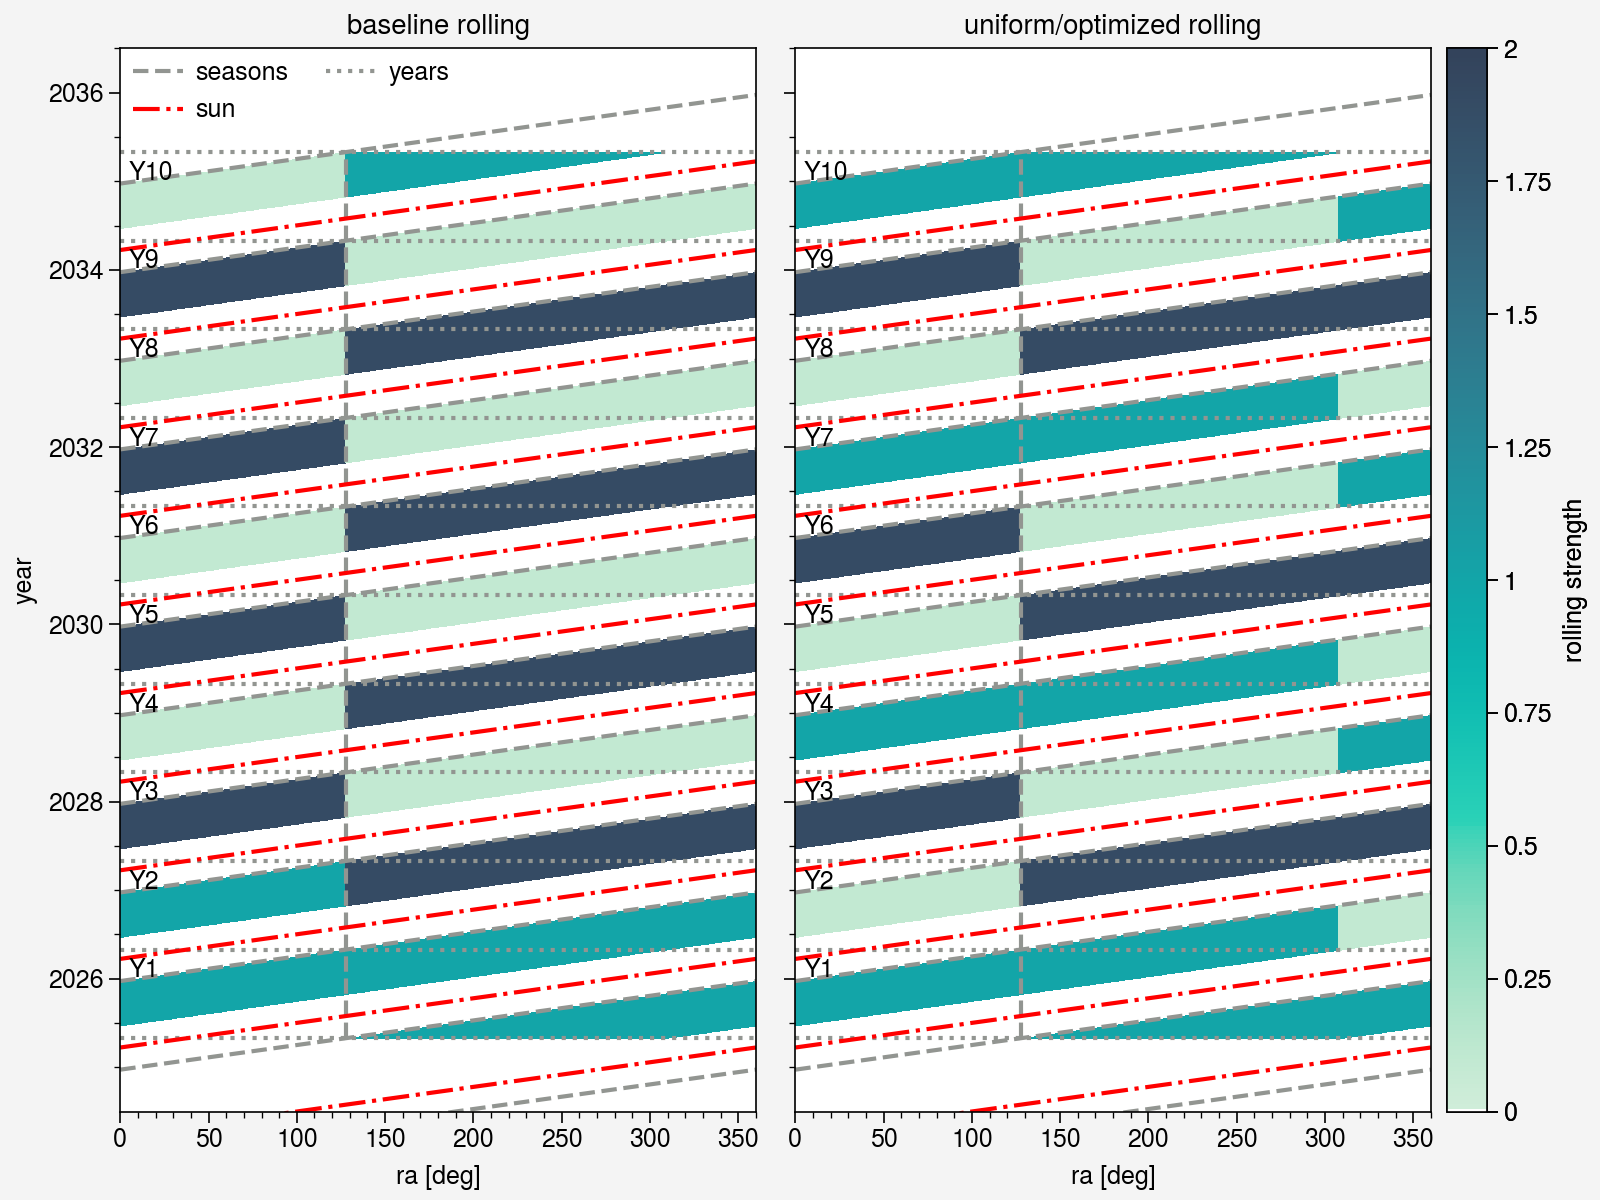

In [56]:
shift = 0
start_time = BASELINE_SURVEY_START_MJD + shift
n_years = 10

run_time = YEAR * n_years
time_grid = np.linspace(start_time, start_time + run_time, n_years * 1000 + 1)
tv = (time_grid[:-1] + time_grid[1:])/2.0
ra_grid = np.linspace(0, 360, 24*10 + 1)
rav = (ra_grid[:-1] + ra_grid[1:])/2.0

rolling_strength = 0.9
U = 1.0 + rolling_strength
D = 2.0 - U

vmin = 0
vmax = 2

cmap = get_cmap_plus_white(cmap="marine")
ylim = (2024.5, 2036.5)
fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharex=0, sharey=4)

# baseline
pattern = [1, 1, U, D, U, D, U, D, U, D, 1, 1]
pattern = np.array(pattern)

seasons = get_season(
    tv.reshape(-1, 1),
    rav.reshape(1, -1),
    start_time,
)
int_seasons = np.floor(seasons).astype(int)
rs = pattern[int_seasons]
msk = seasons - int_seasons >= 0.5
rs[~msk] = np.nan

ax = axs[0, 0]
m = ax.pcolormesh(
    ra_grid,
    (time_grid - MJD_2024) / YEAR + 2024,
    rs,
    vmin=vmin,
    vmax=vmax,
    shading="flat",
    # N=max_obs_ints*8,
    cmap=cmap,
    discrete=False,
)
m = plot_years_and_seasons(ax, start_time, n_years)
m += plot_sun_ra(ax, start_time, n_years, label="sun", color="red", linestyle="dashdot")
ax.format(xlabel="ra [deg]", ylabel="year", title="baseline rolling", ylim=ylim)
ax.legend(m, loc="ul", frameon=False, ncols=2)

# optimized
pattern_a = [1, D, U, 1, D, U, 1, D, U, 1, 1, 1, 1]
pattern_ac = [1, 1, U, D, 1, U, D, 1, U, D, 1, 1, 1]
pattern_b = [1, U, D, 1, U, D, 1, U, D, 1, 1, 1, 1]
pattern_bc = [1, 1, D, U, 1, D, U, 1, D, U, 1, 1, 1]
pattern_a = np.array(pattern_a)
pattern_b = np.array(pattern_b)
pattern_ac = np.array(pattern_ac)
pattern_bc = np.array(pattern_bc)

seasons = get_season(
    tv.reshape(-1, 1),
    rav.reshape(1, -1),
    start_time,
)
int_seasons = np.floor(seasons).astype(int)
rs = pattern_a[int_seasons]
rsc = pattern_ac[int_seasons]

msk = seasons - int_seasons >= 0.5
rs[~msk] = np.nan
rsc[~msk] = np.nan

ra_sun = get_sun_ra_at_mjd(start_time)
msk = (rav >= 90 + ra_sun) & (rav <= 270 + ra_sun)
for i in range(rs.shape[0]):
    rs[i, msk] = rsc[i, msk]

ax = axs[0, 1]
m = ax.pcolormesh(
    ra_grid,
    (time_grid - MJD_2024) / YEAR + 2024,
    rs,
    vmin=vmin,
    vmax=vmax,
    shading="flat",
    # N=max_obs_ints*8,
    cmap=cmap,
    discrete=False,
)
ax.colorbar(
    m,
    loc="r",
    title="rolling strength",
)
plot_years_and_seasons(ax, start_time, n_years)
plot_sun_ra(ax, start_time, n_years, label="sun", color="red", linestyle="dashdot")
ax.format(xlabel="ra [deg]", ylabel="year", title="uniform/optimized rolling", ylim=ylim)

fig.savefig("rolling_seasons.png", dpi=300)

## Viz of Sim results

/Users/beckermr/mambaforge/envs/rubin-sims/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/beckermr/mambaforge/envs/rubin-sims/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/beckermr/mambaforge/envs/rubin-sims/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/beckermr/mambaforge/envs/rubin-sims/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use

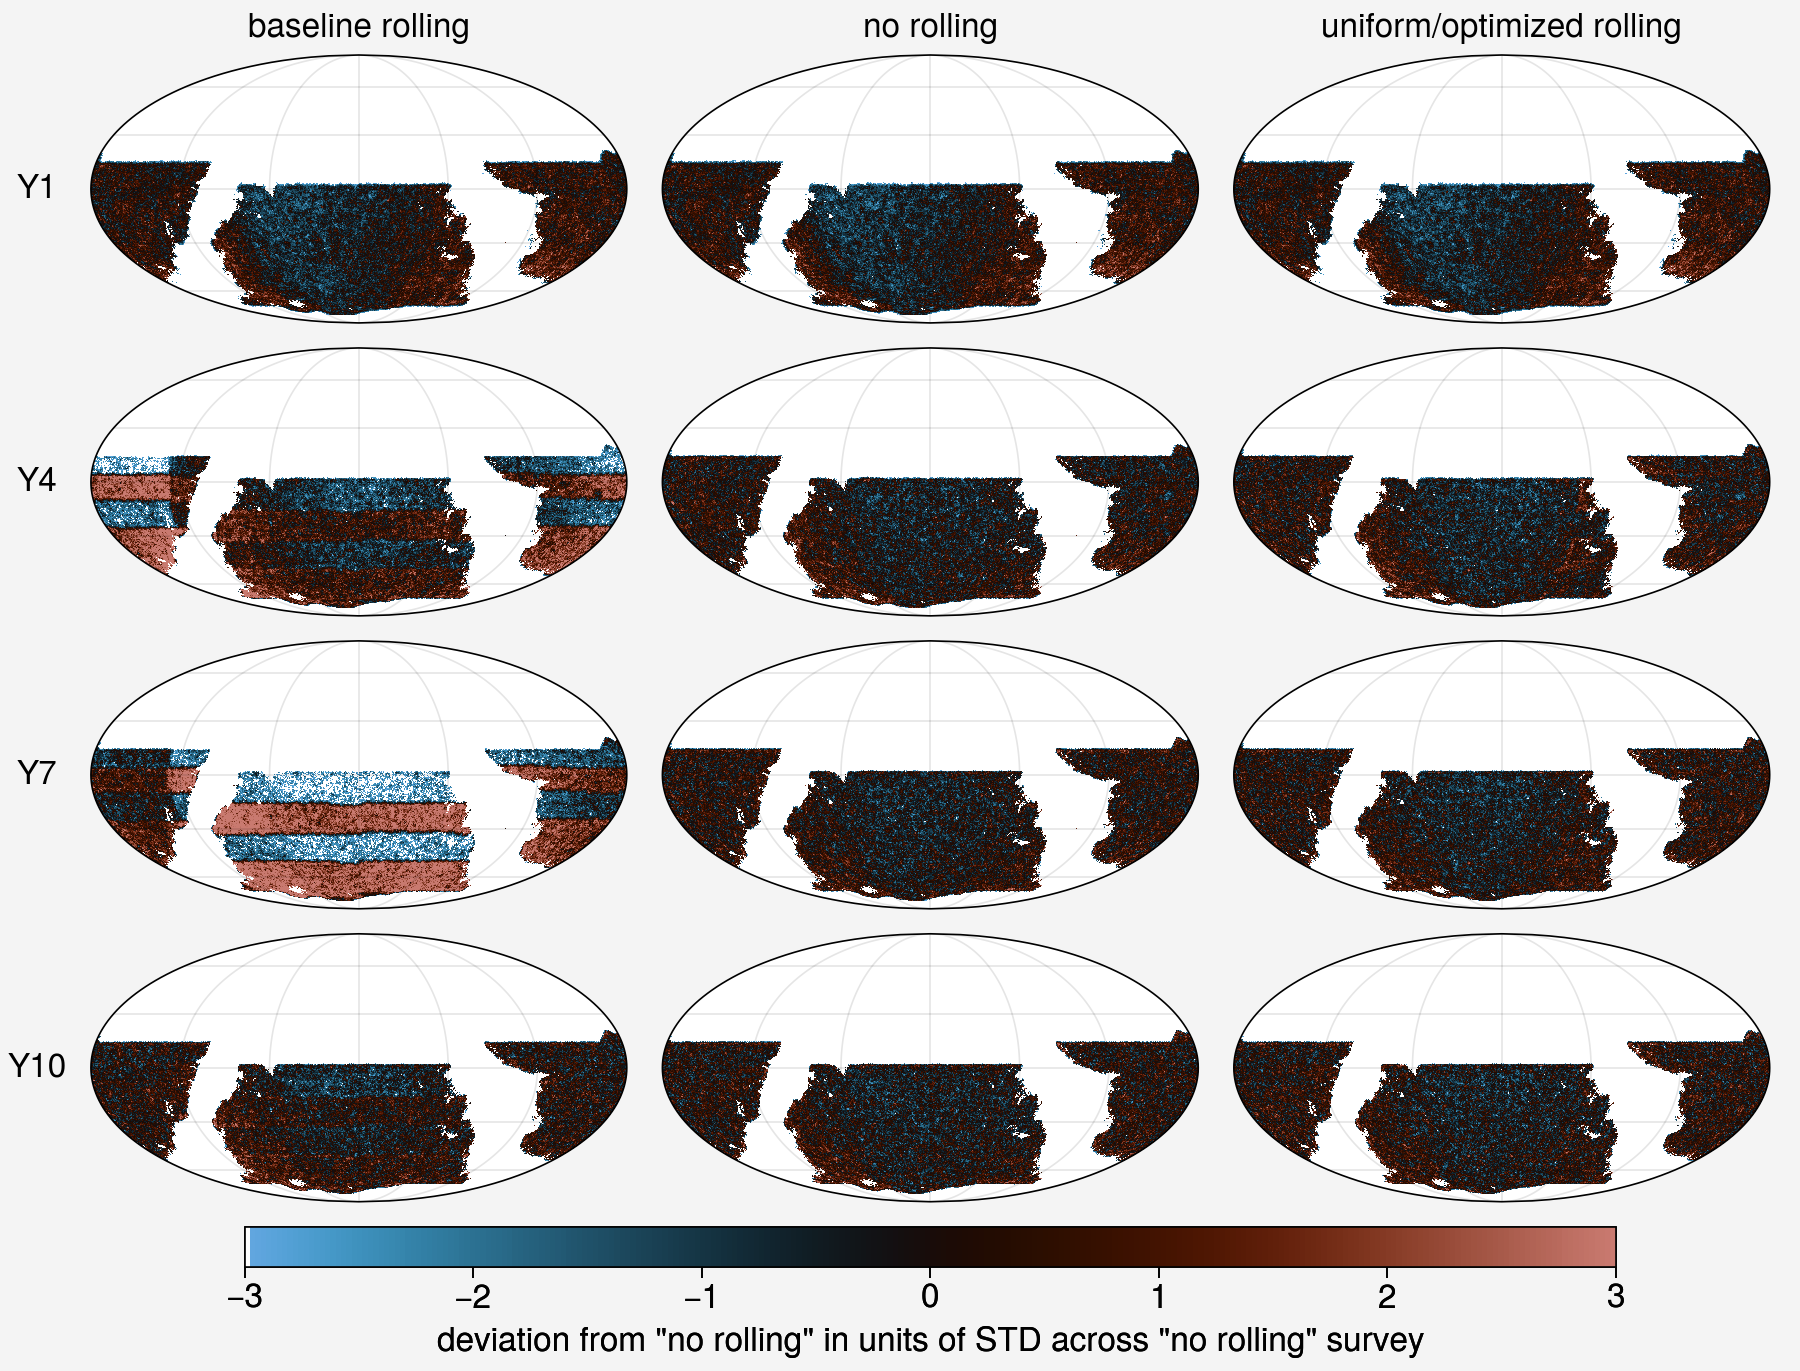

In [55]:
from rubin_sim.scheduler.utils import SkyAreaGenerator
import fitsio

nside = 128

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

baseline_maps_arr = fitsio.read("baseline_v3.4_10yrs_nside128_bins40.fits")
uniform_maps_arr = fitsio.read("noroll_mjdp0_v3.4_10yrs_nside128_bins40.fits")
roll_uniform_maps_arr = fitsio.read("roll_uniform_early_half_mjdp0_v3.4_10yrs_nside128_bins40.fits")

map_labels = [
    "baseline rolling",
    "no rolling",
    "uniform/optimized rolling"
]
maps = [
    baseline_maps_arr,
    uniform_maps_arr,
    roll_uniform_maps_arr
]
year_inds = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39]
year_inds = [3, 15, 27, 39]
width = 3 * len(map_labels)
height = width / len(map_labels) / 1.75 * len(year_inds)

fig, axs = pplt.subplots(
    nrows=len(year_inds), ncols=3,
    proj="moll",
    figsize=(width, height),
)

for axind, yind in enumerate(year_inds):
    smaps = []
    for mind in range(3):
        med_rizexptime_per_year = np.median(uniform_maps_arr[yind, wfd_indx])

        smap = (maps[mind][yind, :] - med_rizexptime_per_year) / med_rizexptime_per_year
        msk = maps[mind][yind, :] < 15
        smap[msk] = -1
        smaps.append(smap)
        if map_labels[mind] == "no rolling":
            scale = mad(smap[~msk])

    smaps = np.array(smaps)
    msk = smaps > -1
    smaps /= scale
    vmax = 3.0

    for mind in range(3):
        ax = axs[axind, mind]

        m = plot_rizexptime_fancy(
            ax,
            smaps[mind],
            1.0,
            vmin=-vmax, vmax=vmax,
            npix=800,
            cmap=get_cmap_plus_white(cmap="berlin"),
        )

        if yind == 3:
            ax.text(
                0.5, 1.1,
                map_labels[mind],
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=12,
            )

        if mind == 0:
            ax.text(
                -0.1, 0.5,
                f"Y{yind // 4 + 1}",
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=12,
            )

fig.colorbar(
    m,
    loc="b",
    label="deviation from \"no rolling\" in units of STD across \"no rolling\" survey",
    length=0.8,
    ticklabelsize=12,
    labelsize=12,
)

fig.savefig("riz_obstime_maps.png", dpi=300)